# Figures

In [1]:
from pathlib import Path

import colorcet as cc
import datashader as ds
import matplotlib.pyplot as plt
import napari
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile
import xarray as xr
from datashader.mpl_ext import dsshow
from scipy.stats import norm, truncnorm

paper_width = 8.3
paper_margin = 1
figure_dpi = "figure"

def save_and_show(figure_file_name):
    plt.savefig(Path("figures") / figure_file_name, dpi=figure_dpi, bbox_inches="tight")
    plt.show()

sns.set_theme(
    context="paper",
    style="ticks",
    palette="colorblind",
    color_codes=True,
)
plt.rcParams.update(
    {
        "figure.figsize": (
            paper_width - 2 * paper_margin,
            (4 / 6) * (paper_width - 2 * paper_margin),
        ),
        "figure.titlesize": 12,  # "large",
        "axes.titlesize": 10,  # 9.6,
        "axes.labelsize": 10,  # 9.6,
        "legend.fontsize": 10,  # 8.8,
        "legend.title_fontsize": 10,  # 9.6,
        "xtick.labelsize": 8,  # 8.8,
        "xtick.major.size": 7,  # 4.8,
        "xtick.minor.size": 5,  # 3.2,
        "ytick.labelsize": 8,  # 8.8,
        "ytick.major.size": 7,  # 4.8,
        "ytick.minor.size": 5,  # 3.2,
        "font.size": 10,  # 9.6,
        "font.family": 'lmodern',
        "text.usetex": True,
        "text.latex.preamble": " ".join([
            r"\usepackage{amsmath}",
            r"\usepackage{lmodern}",
        ]),
    }
)
    
sns.color_palette()

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

## Figure 1: summary

Created with BioRender

## Figure 2: cell miss probability

In [3]:
cell_data = pd.read_csv("datasets/kuett_catena_2022/sectioning/cell_data.csv")
cell_slice_data = pd.read_csv("datasets/kuett_catena_2022/sectioning/cell_slice_data.csv")

In [4]:
# empirically observed cell section spans

def get_empirical_cell_section_span(sectioning_axis_name):
    df = cell_slice_data[cell_slice_data["sectioning_axis_name"] == sectioning_axis_name]
    df = df.groupby(["section_thickness_um", "section_offset_um", "cell_id"]).size().reset_index(name="cell_section_span")
    df = df.groupby(["section_thickness_um", "cell_id"])["cell_section_span"].mean().reset_index(name="cell_section_span")    
    df = pd.merge(df, cell_data.loc[cell_data["sectioning_axis_name"] == "z", ["cell_id", "proj_cell_radius_um"]])
    n_short = np.floor(df["section_thickness_um"] - ((2 * df["proj_cell_radius_um"]) % df["section_thickness_um"])) + 1
    n_long = np.ceil((2 * df["proj_cell_radius_um"]) % df["section_thickness_um"]) - 1
    df["cell_section_span"] = (n_short * df["cell_section_span"] + n_long * (df["cell_section_span"] - 1)) / (n_short + n_long)
    return df

In [5]:
# model fitted to empirically observed radii

t_obs = cell_slice_data["section_thickness_um"].unique()
d_obs = 2 * cell_data.loc[cell_data["sectioning_axis_name"] == "z", "proj_cell_radius_um"].to_numpy()

mu_d = d_obs.mean()
sigma_d = d_obs.std()

n = len(d_obs)
t = t_obs
d = truncnorm.rvs(-mu_d / sigma_d, mu_d / sigma_d, loc=mu_d, scale=sigma_d, size=n, random_state=123)
s = np.ceil(d[:, np.newaxis] / t[np.newaxis, :])

mu_d, sigma_d ** 2

(7.9312735863614465, 3.1263231347964675)

In [8]:
def plot_cell_diameter(num=1000, **kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.kdeplot(
        x=2 * cell_data.loc[cell_data["sectioning_axis_name"] == "z", "proj_cell_radius_um"],
        label=r"$d_z = 2 \sqrt{\frac{A_z}{\pi}}$",
        linestyle="-",
        color="C7",
        legend=False,
        ax=ax,
        **kwargs,
    )
    x = np.linspace(
        2 * cell_data.loc[cell_data["sectioning_axis_name"] == "z", "proj_cell_radius_um"].min(),
        2 * cell_data.loc[cell_data["sectioning_axis_name"] == "z", "proj_cell_radius_um"].max(),
        num,
    )
    y = norm.pdf(x, loc=mu_d, scale=sigma_d)
    ax.plot(x, y, label=r"$D \sim \mathcal{N}(\mu_d, \sigma_d^2)$", linestyle=":", color="C7")
    ax.set_title(r"Cell diameter (circular approximation)")
    ax.set_xlabel(r"Diameter [$\mu m$]")
    ax.set_ylabel(r"Density")
    ax.legend(loc="upper right")

In [7]:
mask = tifffile.imread("datasets/kuett_catena_2022/sectioning/mask.tiff")
mask = np.pad(mask, ((20, 20), (40, 40), (40, 40)))
mask[mask.shape[0] // 2, :, :] = np.amax(mask) + 1
mask[:, mask.shape[1] // 2, :] = mask[:, :, mask.shape[2] // 2] = np.amax(mask) + 6

viewer = napari.view_labels(mask, scale=(2, 1, 1), ndisplay=3)
viewer.camera.angles=(-20, 40, -30)

In [9]:
mask_screenshot = viewer.screenshot()
viewer.close()

def plot_mask_screenshot(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.imshow(np.where(mask_screenshot != 0, mask_screenshot, 255))
    ax.axis("off")

In [10]:
def plot_cell_section_span(**kwargs):
    ax = kwargs.pop("ax", plt.gca())
    data = pd.concat(
        {
            ("Sx", "sectioning"): get_empirical_cell_section_span("x"),            
            ("Sy", "sectioning"): get_empirical_cell_section_span("y"),            
            ("Sz", "sectioning"): get_empirical_cell_section_span("z"),
            ("S", "model"): pd.DataFrame(data=s, columns=t).melt(var_name="section_thickness_um", value_name="cell_section_span"),
        },
        names=["hue", "style", ""],
    ).reset_index()
    data["section_thickness_um"] = data["section_thickness_um"].astype("category")
    g = sns.lineplot(
        data=data,
        x="section_thickness_um",
        y="cell_section_span",
        hue="hue",
        style="style",
        hue_order=["Sx", "Sy", "Sz", "S"],
        dashes={"sectioning": "", "model": (1, 1)},
        palette=["C0", "C1", "C2", "C7"],
        marker="o",
        ci=None,
        legend=False,
        ax=ax,
        **kwargs,
    )
    ax.set_title(r"Cell section span")
    ax.set_xlabel(r"Section thickness [$\mu m$]")
    ax.set_ylabel(r"Number of sections (mean)")
    ax.legend(
        labels=[
            r"adjusted $s_x$",
            r"adjusted $s_y$",
            r"adjusted $s_z$",
            r"$S = \lceil Dt^{-1} \rceil$",
        ],
        loc="upper right",
    )

In [11]:
def plot_cell_miss_probab(**kwargs):
    ax = kwargs.pop("ax", plt.gca())
    data = pd.DataFrame(data=1 / s, columns=t).melt(
        var_name="section_thickness_um", value_name="cell_miss_probab"
    )
    data["section_thickness_um"] = data["section_thickness_um"].astype("category")
    sns.kdeplot(
        data=data,
        x="cell_miss_probab",
        hue="section_thickness_um",
        bw_method=1,
        ax=ax,
        linestyle=":",  # same as (1, 1)
        **kwargs,
    )
    sns.rugplot(
        data=data.drop_duplicates(),
        x="cell_miss_probab",
        hue="section_thickness_um",
        height=0.05,
        ax=ax,
    )
    sns.move_legend(ax, "upper right", title="Section thickness [$\\mu m$]", ncol=2)
    ax.set_title(r"Cell miss probability (bw=$1.0$)")
    ax.set_xlabel(r"$P($cell absent in next section$) = S^{-1}$")
    ax.set_ylabel(r"Density")
    ax.set_xlim(0, 1)

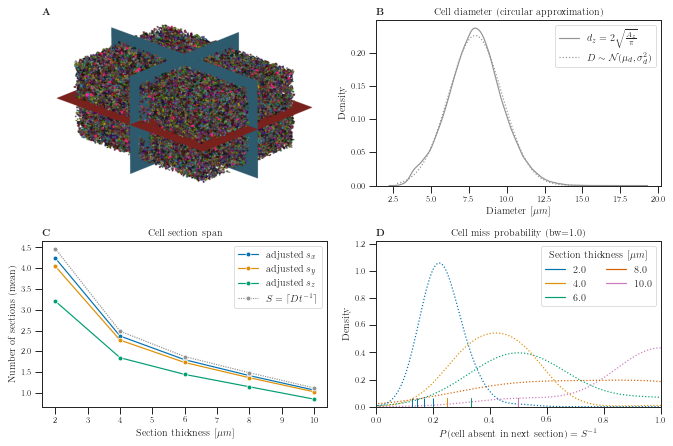

In [12]:
fig, axes = plt.subplot_mosaic(
    """AB
       CD""",
    figsize=(1.5 * plt.rcParams["figure.figsize"][0], 1.5 * plt.rcParams["figure.figsize"][1]),
)
plot_mask_screenshot(ax=axes["A"])
plot_cell_diameter(ax=axes["B"])
plot_cell_section_span(ax=axes["C"])
plot_cell_miss_probab(ax=axes["D"])
plt.tight_layout()
for label, ax in axes.items():
    ax.set_title(f"\\textbf{{{label}}}", loc="left")
save_and_show("Figure2.pdf")

## Figure 3: parameter optimization

In [13]:
def plot_metric_distribution_by_assignment_strategy(data, metric_name, title, ylabel, **kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.violinplot(
        x="assignment_name",
        y="metric_value",
        data=data[data["metric_name"] == metric_name],
        order=[
            "linear_sum",
            "max_intersect",
            "max_union",
            "max_union_thresQ05",
            "max_union_thresQ15",
            "max_union_thresQ25",
        ],
        inner=kwargs.pop("inner", "quartile"),
        ax=ax,
        **kwargs,
    )
    ax.set_title(title)
    ax.set_xlabel("Assignment strategy")
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(
        [
            "linear sum",
            "max-intersect",
            "max-union ($q=0$)",
            "max-union ($q=0.05$)",
            "max-union ($q=0.15$)",
            "max-union ($q=0.25$)",
        ],
        rotation=20,
        ha="right",
    )
    ax.set_ylim(-0.15, 1.15)

In [14]:
def plot_max_intersect_f1score_distribution_by_parameter_value(data, parameter_column, title, xlabel, **kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.violinplot(
        x=parameter_column,
        y="metric_value",
        data=data[
            (data["assignment_name"] == "max_intersect")
            & (data["metric_name"] == "f1score")
        ],
        inner="point",
        ax=ax,
        **kwargs,
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r"$F_1$-score (max-intersect)")
    ax.set_ylim(-0.15, 1.15)

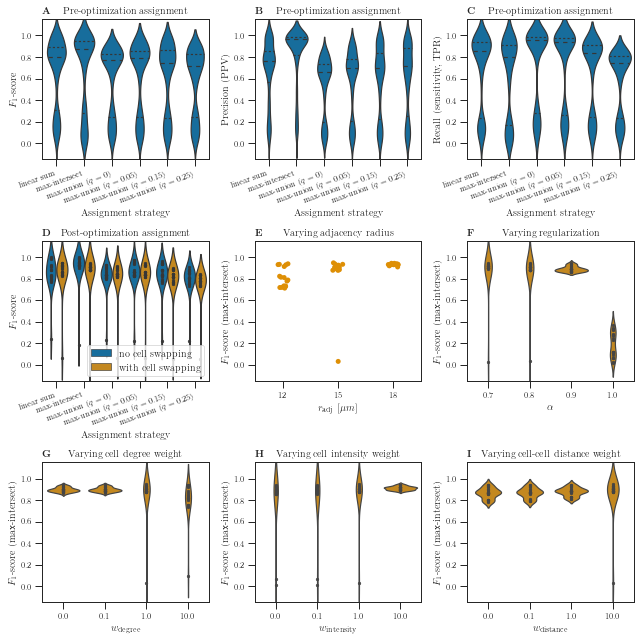

In [15]:
fig, axes = plt.subplot_mosaic(
    """ABC
       DEF
       GHI""",
    figsize=(1.5 * plt.rcParams["figure.figsize"][0], 1.5 * plt.rcParams["figure.figsize"][0]),
)

optim_noswap_pre_results = pd.read_csv("benchmarks/optim_noswap_pre/results/results.csv")
plot_metric_distribution_by_assignment_strategy(
    optim_noswap_pre_results,
    "f1score",
    "Pre-optimization assignment",
    "$F_1$-score",
    ax=axes["A"],
    color="C0",
)
plot_metric_distribution_by_assignment_strategy(
    optim_noswap_pre_results,
    "precision",
    "Pre-optimization assignment",
    "Precision (PPV)",
    ax=axes["B"],
    color="C0",
)
plot_metric_distribution_by_assignment_strategy(
    optim_noswap_pre_results,
    "recall",
    "Pre-optimization assignment",
    "Recall (sensitivity, TPR)",
    ax=axes["C"],
    color="C0",
)

optim_noswap_results = pd.read_csv("benchmarks/optim_noswap/results/results.csv")
optim_swap_alpha_results = pd.read_csv("benchmarks/optim_swap_alpha/results/results.csv")
data = pd.concat(
    {
        "no cell swapping": optim_noswap_results,
        "with cell swapping": optim_swap_alpha_results[optim_swap_alpha_results["spellmatch_alpha"] == 0.8],
    },
    names=["Benchmark", None],
).reset_index(level=0)
plot_metric_distribution_by_assignment_strategy(
    data,
    "f1score",
    "Post-optimization assignment",
    "$F_1$-score",
    ax=axes["D"],
    hue="Benchmark",
    palette=["C0", "C1"],
    inner="point",
)
sns.move_legend(axes["D"], loc="lower right", title=None)

optim_swap_radius_results = pd.read_csv("benchmarks/optim_swap_radius/results/results.csv")
sns.stripplot(
    x="spellmatch_adj_radius",
    y="metric_value",
    data=optim_swap_radius_results[
        (optim_swap_radius_results["assignment_name"] == "max_intersect")
        & (optim_swap_radius_results["metric_name"] == "f1score")
    ],
    ax=axes["E"],
    color="C1",
)
axes["E"].set_title("Varying adjacency radius")
axes["E"].set_xlabel(r"$r_\mathrm{adj}$ [$\mu m$]")
axes["E"].set_ylabel(r"$F_1$-score (max-intersect)")
axes["E"].set_ylim(-0.15, 1.15)

optim_swap_alpha_results = pd.read_csv("benchmarks/optim_swap_alpha/results/results.csv")
plot_max_intersect_f1score_distribution_by_parameter_value(
    optim_swap_alpha_results,
    "spellmatch_alpha",
    "Varying regularization",
    r"$\alpha$",
    ax=axes["F"],
    color="C1",
)

optim_swap_degree_weight_results = pd.read_csv("benchmarks/optim_swap_degree_weight/results/results.csv")
plot_max_intersect_f1score_distribution_by_parameter_value(
    optim_swap_degree_weight_results,
    "spellmatch_degree_weight",
    "Varying cell degree weight",
    r"$w_\mathrm{degree}$",
    ax=axes["G"],
    color="C1",
)

optim_swap_intensity_weight_results = pd.read_csv("benchmarks/optim_swap_intensity_weight/results/results.csv")
plot_max_intersect_f1score_distribution_by_parameter_value(
    optim_swap_intensity_weight_results,
    "spellmatch_intensity_weight",
    "Varying cell intensity weight",
    r"$w_\mathrm{intensity}$",
    ax=axes["H"],
    color="C1",
)

optim_swap_distance_weight_results = pd.read_csv("benchmarks/optim_swap_distance_weight/results/results.csv")
plot_max_intersect_f1score_distribution_by_parameter_value(
    optim_swap_distance_weight_results,
    "spellmatch_distance_weight",
    "Varying cell-cell distance weight",
    r"$w_\mathrm{distance}$",
    ax=axes["I"],
    color="C1",
)

plt.tight_layout()
for label, ax in axes.items():
    ax.set_title(f"\\textbf{{{label}}}", loc="left")
save_and_show("Figure3.pdf")

## Figure 4: algorithm benchmark

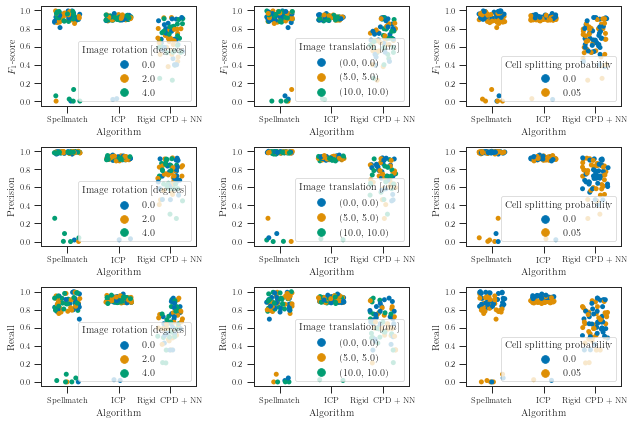

In [16]:
benchmark_results = pd.concat(
    (
        pd.read_csv("benchmarks/benchmark_spellmatch/results/results.csv"),
        pd.read_csv("benchmarks/benchmark_others/results/results.csv"),
    )
)
benchmark_results = benchmark_results[benchmark_results["algorithm_converged"] != False]
benchmark_results["simutome_image_rotation_degrees"] = np.around(180 * benchmark_results["simutome_image_rotation"] / np.pi)

def plot_benchmark_results(metric_name, ylabel, hue, legend_title, **kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.stripplot(
        data=benchmark_results[
            (benchmark_results["assignment_name"] == "max_intersect")
            & (benchmark_results["metric_name"] == metric_name)
        ],
        x="algorithm_config_name",
        order=["spellmatch", "icp", "rigid_cpd"],
        y="metric_value",
        hue=hue,
        ax=ax,
        **kwargs,
    )
    ax.set_xlabel("Algorithm")
    ax.set_ylabel(ylabel)
    sns.move_legend(ax, loc="lower right", title=legend_title)
    ax.set_xticklabels(["Spellmatch", "ICP", "Rigid CPD + NN"])

fig, axes = plt.subplot_mosaic(
    """ABC
       DEF
       GHI""",
    figsize=(1.5 * plt.rcParams["figure.figsize"][0], 1.5 * plt.rcParams["figure.figsize"][1]),
)
plot_benchmark_results("f1score", "$F_1$-score", "simutome_image_rotation_degrees", "Image rotation [degrees]", ax=axes["A"], jitter=0.25)
plot_benchmark_results("f1score", "$F_1$-score", "simutome_image_translation", "Image translation [$\\mu m$]", ax=axes["B"], jitter=0.25)
plot_benchmark_results("f1score", "$F_1$-score", "simutome_cell_division_probab", "Cell splitting probability", ax=axes["C"], jitter=0.25)
plot_benchmark_results("precision", "Precision", "simutome_image_rotation_degrees", "Image rotation [degrees]", ax=axes["D"], jitter=0.25)
plot_benchmark_results("precision", "Precision", "simutome_image_translation", "Image translation [$\\mu m$]", ax=axes["E"], jitter=0.25)
plot_benchmark_results("precision", "Precision", "simutome_cell_division_probab", "Cell splitting probability", ax=axes["F"], jitter=0.25)
plot_benchmark_results("recall", "Recall", "simutome_image_rotation_degrees", "Image rotation [degrees]", ax=axes["G"], jitter=0.25)
plot_benchmark_results("recall", "Recall", "simutome_image_translation", "Image translation [$\\mu m$]", ax=axes["H"], jitter=0.25)
plot_benchmark_results("recall", "Recall", "simutome_cell_division_probab", "Cell splitting probability", ax=axes["I"], jitter=0.25)

plt.tight_layout()
save_and_show("Figure4.pdf")

## Figure 5: application example

Created with spellmatch

# Supplementary Figures

## Figure S1: single-cell statistics for 3D modeling

In [17]:
cell_data = pd.read_csv("datasets/kuett_catena_2022/sectioning/cell_data.csv")

In [18]:
def plot_cell_volume_distribution(**kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.kdeplot(
        x=cell_data.groupby("cell_id")["cell_volume_um3"].mean(),
        color="C0",
        ax=ax,
        **kwargs,
    )
    ax.set_title("Cell volume")
    ax.set_xlabel(r"Volume [$\mu m^3$]")
    ax.legend([r"$V$"])

In [19]:
def plot_cell_area_distributions(**kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.kdeplot(
        data=cell_data,
        x="proj_cell_area_um2",
        hue="sectioning_axis_name",
        hue_order=["z", "y", "x"],
        palette=["C1", "C2", "C3"],
        ax=ax,
        **kwargs,
    )
    ax.set_title("Cell area (maximum projection)")
    ax.set_xlabel(r"Area [$\mu m^2$]")
    ax.legend_.set_title(None)
    for text, label in zip(ax.legend_.texts, [ r"$A_z$", r"$A_y$", r"$A_x$"]):
        text.set_text(label)

In [20]:
def plot_cell_radius_distributions(**kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.kdeplot(
        data=cell_data[cell_data["sectioning_axis_name"] == "z"],
        x="cell_radius_um",
        color="C0",
        legend=False,
        ax=ax,
        **kwargs,
    )
    sns.kdeplot(
        data=cell_data,
        x="proj_cell_radius_um",
        hue="sectioning_axis_name",
        hue_order=["z", "y", "x"],
        palette=["C1", "C2", "C3"],
        legend=False,
        ax=ax,
        **kwargs,
    )
    ax.set_title("Cell radius (circular/spherical approximations)")
    ax.set_xlabel(r"Radius [$\mu m$]")
    ax.legend(
        #handles=ax.lines[:3][::-1] + ax.lines[3:],
        labels=[
            r"$r = \sqrt[3]{\frac{3 V}{4 \pi}}$",
            r"$r_z = \sqrt{\frac{A_x}{\pi}}$",
            r"$r_y = \sqrt{\frac{A_y}{\pi}}$",
            r"$r_x = \sqrt{\frac{A_z}{\pi}}$",
        ],
    )

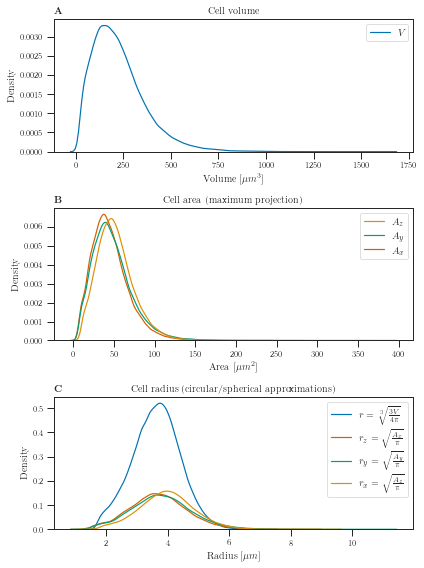

In [21]:
fig, axes = plt.subplot_mosaic(
    """A
       B
       C""",
    figsize=(plt.rcParams["figure.figsize"][0], 2 * plt.rcParams["figure.figsize"][1]),
)

plot_cell_volume_distribution(ax=axes["A"])
plot_cell_area_distributions(ax=axes["B"])
plot_cell_radius_distributions(ax=axes["C"])

plt.tight_layout()
for label, ax in axes.items():
    ax.set_title(f"\\textbf{{{label}}}", loc="left")
save_and_show("FigureS1.pdf")

## Figure S2: cell centroid displacement (synthetic sectioning)

In [2]:
cell_slice_displacement_data = pd.read_csv("datasets/kuett_catena_2022/sectioning/cell_slice_displacement_data.csv")

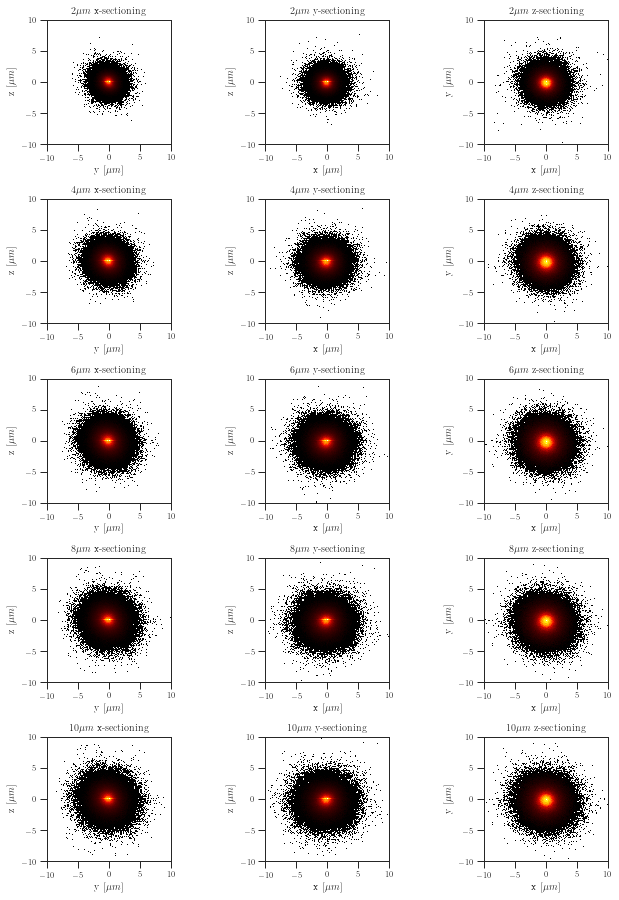

In [3]:
sectioning_axis_names = ("x", "y", "z")
fig, axes = plt.subplots(
    nrows=cell_slice_displacement_data["section_thickness_um"].nunique(),
    ncols=3,
    figsize=(1.5 * plt.rcParams["figure.figsize"][0], 3 * plt.rcParams["figure.figsize"][1]),
)
for row_axes, (section_thickness_um, g) in zip(axes, cell_slice_displacement_data.groupby("section_thickness_um")):
    for ax, sectioning_axis_name in zip(row_axes, sectioning_axis_names):
        x, y = tuple(a for a in sectioning_axis_names if a != sectioning_axis_name)
        dsshow(
            g[g["sectioning_axis_name"] == sectioning_axis_name],
            ds.Point(f"cell_slice_centroid_displacement_{x}_um", f"cell_slice_centroid_displacement_{y}_um"),
            cmap=cc.fire,
            ax=ax,
        )
        ax.set_title(f"${section_thickness_um:g} \\mu m$ {sectioning_axis_name}-sectioning")
        ax.set_xlabel(f"{x} [$\\mu m$]")
        ax.set_ylabel(f"{y} [$\\mu m$]")
        ax.set_ylim(-10, 10)
        ax.set_xlim(-10, 10)

plt.tight_layout()
save_and_show("FigureS2.pdf")

## Figure S3: image selection for semi-synthetic data generation

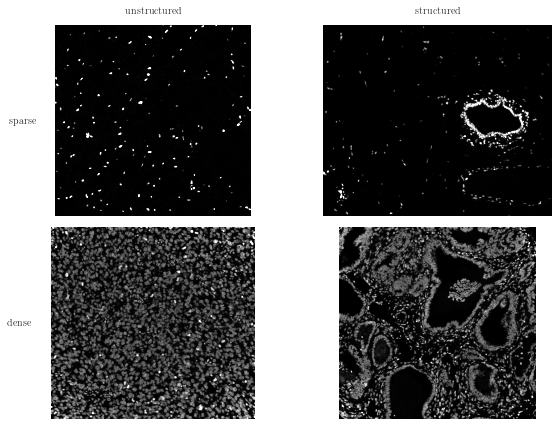

In [5]:
fig, axes = plt.subplot_mosaic(
    """AB
       CD""",
    figsize=(1.5 * plt.rcParams["figure.figsize"][0], 1.5 * plt.rcParams["figure.figsize"][1]),
)

img = tifffile.imread("datasets/jackson_fischer_2020/raw/img/sparse_homogeneous.tiff")
axes["A"].imshow(img[48], cmap="Greys_r", vmax=np.quantile(img[48], 0.995))
axes["A"].axis("off")
axes["A"].text(-0.1, 0.5, "sparse", transform=axes["A"].transAxes, ha="right", va="center")
axes["A"].text(0.5, 1.05, "unstructured", transform=axes["A"].transAxes, ha="center", va="bottom")

img = tifffile.imread("datasets/jackson_fischer_2020/raw/img/sparse_heterogeneous.tiff")
axes["B"].imshow(img[48], cmap="Greys_r", vmax=np.quantile(img[48], 0.995))
axes["B"].axis("off")
axes["B"].text(0.5, 1.05, "structured", transform=axes["B"].transAxes, ha="center", va="bottom")

img = tifffile.imread("datasets/jackson_fischer_2020/raw/img/dense_homogeneous.tiff")
axes["C"].imshow(img[48], cmap="Greys_r", vmax=np.quantile(img[48], 0.995))
axes["C"].axis("off")
axes["C"].text(-0.1, 0.5, "dense", transform=axes["C"].transAxes, ha="right", va="center")

img = tifffile.imread("datasets/jackson_fischer_2020/raw/img/dense_heterogeneous.tiff")
axes["D"].imshow(img[48], cmap="Greys_r", vmax=np.quantile(img[48], 0.995))
axes["D"].axis("off")

plt.tight_layout()
save_and_show("FigureS3.pdf")

## Figure S4: post-optimization assignment performance

In [6]:
optim_noswap_results = pd.read_csv("benchmarks/optim_noswap/results/results.csv")

def plot_metric_distribution_by_assignment_strategy(metric_name, title, ylabel, **kwargs):
    ax = kwargs.pop("ax", plt.gca())
    sns.violinplot(
        x="assignment_name",
        y="metric_value",
        data=optim_noswap_results[optim_noswap_results["metric_name"] == metric_name],
        order=[
            "linear_sum",
            "max_intersect",
            "max_union",
            "max_union_thresQ05",
            "max_union_thresQ15",
            "max_union_thresQ25",
        ],
        color="C0",
        inner="point",
        ax=ax,
        **kwargs,
    )
    ax.set_title(title)
    ax.set_xlabel("Assignment strategy")
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(
        [
            "linear sum",
            "max-intersect",
            "max-union ($q=0$)",
            "max-union ($q=0.05$)",
            "max-union ($q=0.15$)",
            "max-union ($q=0.25$)",
        ],
        rotation=20,
        ha="right",
    )
    ax.set_ylim(-0.15, 1.15)

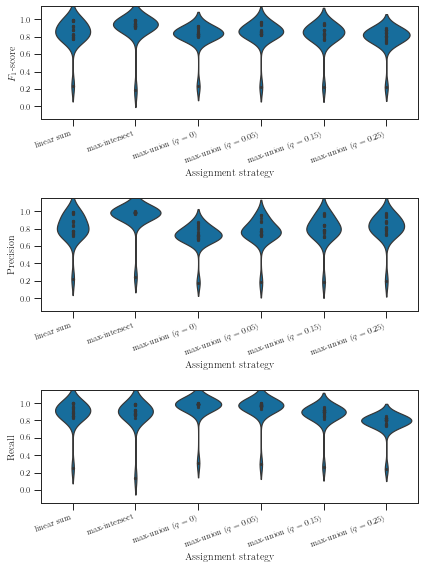

In [7]:
fig, axes = plt.subplot_mosaic(
    """A
       B
       C""",
    figsize=(plt.rcParams["figure.figsize"][0], 2 * plt.rcParams["figure.figsize"][1]),
)
plot_metric_distribution_by_assignment_strategy("f1score", "", "$F_1$-score", ax=axes["A"])
plot_metric_distribution_by_assignment_strategy("precision", "", "Precision", ax=axes["B"])
plot_metric_distribution_by_assignment_strategy("recall", "", "Recall", ax=axes["C"])
plt.tight_layout()
plt.subplots_adjust(hspace=0.7)
save_and_show("FigureS4.pdf")

## Figure S5: Interactive cell matching screenshot

Created externally

## Figure S6: Automatic image registration screenshot

Created externally

## Figure S7: uncertainty quantification (application example)

/tmp/ipykernel_245272/916462672.py:11: RuntimeWarning: invalid value encountered in multiply
  "entropy": -np.sum(scores * np.log(scores, where=scores != 0), axis=1),


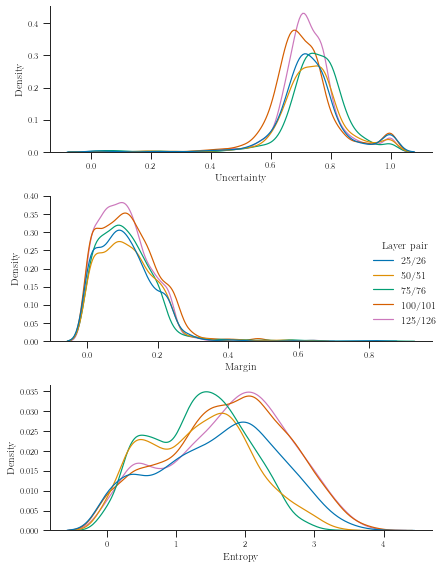

In [8]:
dfs = {}
scores_files = sorted(Path("datasets/kuett_catena_2022/scores_spellmatch").glob("*.nc"))
for scores_file in scores_files:
    scores = xr.load_dataarray(scores_file).to_numpy()
    scores /= scores.max()
    max2_scores = -np.partition(-scores, 1, axis=1)[:, :2]
    dfs[scores_file.name] = pd.DataFrame(
        data={
            "uncertainty": 1 - max2_scores[:, 0],
            "margin": max2_scores[:, 0] - max2_scores[:, 1],
            "entropy": -np.sum(scores * np.log(scores, where=scores != 0), axis=1),
        }
    )
data = pd.concat(dfs, names=["scores_file", None]).reset_index(level=0)
g = sns.displot(
    x="metric_value",
    row="metric_name",
    row_order=["uncertainty", "margin", "entropy"],
    hue="scores_file",
    hue_order=[scores_file.name for scores_file in scores_files],
    data=data.melt(id_vars="scores_file", var_name="metric_name", value_name="metric_value"),
    kind="kde",
    facet_kws=dict(sharex=False, sharey=False),
    height=2 * plt.rcParams["figure.figsize"][1] / 3,
    aspect=(4 / 6) * (plt.rcParams["figure.figsize"][1] / 3),
)
g.set_titles("")
g.legend.set_title("Layer pair")
for i, text in enumerate(g.legend.texts):
    text.set_text(f"{(i + 1) * 25}/{(i + 1) * 25 + 1}")
for ax, xlabel in zip(g.axes.flat, ["Uncertainty", "Margin", "Entropy"]):
    ax.set_xlabel(xlabel)
plt.tight_layout()
save_and_show("FigureS7.pdf")